# EXPLORATION_13

# 프로젝트 : CIFAR-10 이미지 생성하기

In [486]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

## 1. 데이터셋 구성하기

In [487]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [488]:
# 각 픽셀은 0~255 사이의 정숫값
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


#### 학습에 사용할 train_x의 이미지를 -1, 1로 정규화

In [489]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


#### 시각화를 통해 학습데이터 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

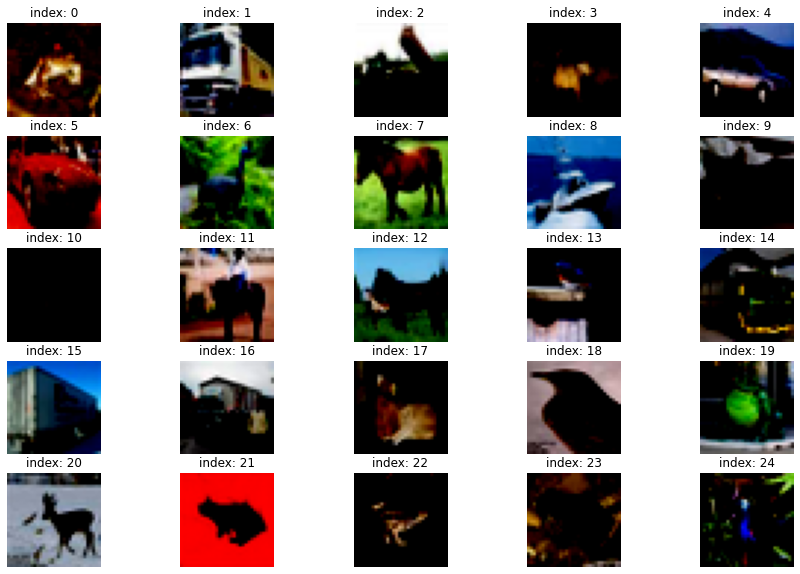

In [490]:
plt.figure(figsize=(15, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

#### 미니배치 데이터셋을 구성

In [491]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [492]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 2. 생성자 모델 구현하기

#### (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성하기

In [493]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,))) #noise
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha = 0.2))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha = 0.2))
    #model.add(layers.Dropout(0.3))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha = 0.2))
    #model.add(layers.Dropout(0.3))

  
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [494]:
generator = make_generator_model()

generator.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_48 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_82 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_14 (Reshape)         (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_48 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_49 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_83 (LeakyReLU)   (None, 8, 8, 128)       

In [495]:
noise = tf.random.normal([1,100])

In [496]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [497]:
generated_image[0, :, :, :]

<tf.Tensor: shape=(32, 32, 3), dtype=float32, numpy=
array([[[-2.9695657e-04, -9.0460654e-04, -2.9886290e-03],
        [-9.7020279e-04, -3.5060397e-03, -8.9165347e-05],
        [ 6.3227983e-03, -4.1199001e-03,  1.7132809e-03],
        ...,
        [ 8.6055361e-03, -5.5093393e-03,  3.5632215e-03],
        [-5.0659785e-03, -1.9180572e-03, -7.1693878e-03],
        [-2.9612815e-03, -5.2747554e-03, -1.8800886e-03]],

       [[-1.4983831e-03, -4.1417303e-03,  4.8348419e-03],
        [-2.1199961e-03, -5.4933601e-03,  6.3037709e-03],
        [-4.6612979e-03,  5.4732934e-03,  7.5729508e-03],
        ...,
        [ 1.0855990e-03, -3.2584113e-04,  3.4611006e-03],
        [ 2.5254029e-03,  1.9654979e-03,  1.5217828e-02],
        [ 8.2557416e-03,  3.2413460e-03,  2.8134480e-03]],

       [[ 1.2575121e-03,  2.0011000e-03, -4.6322323e-04],
        [ 2.2971225e-03,  2.6115065e-03,  2.7888790e-03],
        [-8.6379499e-04, -1.4157742e-02, -1.8398761e-03],
        ...,
        [ 1.0907993e-02,  3.016887

In [498]:
generated_image[0, :, :, :]+1

<tf.Tensor: shape=(32, 32, 3), dtype=float32, numpy=
array([[[0.99970305, 0.9990954 , 0.99701136],
        [0.9990298 , 0.99649394, 0.99991083],
        [1.0063227 , 0.9958801 , 1.0017133 ],
        ...,
        [1.0086055 , 0.9944907 , 1.0035632 ],
        [0.994934  , 0.9980819 , 0.99283063],
        [0.9970387 , 0.9947252 , 0.9981199 ]],

       [[0.9985016 , 0.99585825, 1.0048349 ],
        [0.99788   , 0.99450666, 1.0063038 ],
        [0.9953387 , 1.0054733 , 1.007573  ],
        ...,
        [1.0010856 , 0.99967414, 1.0034611 ],
        [1.0025254 , 1.0019655 , 1.0152178 ],
        [1.0082557 , 1.0032413 , 1.0028135 ]],

       [[1.0012575 , 1.002001  , 0.99953675],
        [1.0022972 , 1.0026115 , 1.0027889 ],
        [0.9991362 , 0.9858422 , 0.9981601 ],
        ...,
        [1.010908  , 1.0030168 , 1.0008755 ],
        [1.0075469 , 0.99546456, 0.9938222 ],
        [0.9945864 , 1.0130227 , 1.0015283 ]],

       ...,

       [[1.0006276 , 0.9950491 , 0.9963607 ],
        [0.9998

In [499]:
(generated_image[0, :, :, :]+1)/2

<tf.Tensor: shape=(32, 32, 3), dtype=float32, numpy=
array([[[0.49985152, 0.4995477 , 0.49850568],
        [0.4995149 , 0.49824697, 0.49995542],
        [0.5031614 , 0.49794006, 0.50085664],
        ...,
        [0.50430274, 0.49724534, 0.5017816 ],
        [0.497467  , 0.49904096, 0.49641532],
        [0.49851936, 0.4973626 , 0.49905995]],

       [[0.4992508 , 0.49792913, 0.50241745],
        [0.49894   , 0.49725333, 0.5031519 ],
        [0.49766934, 0.5027366 , 0.5037865 ],
        ...,
        [0.5005428 , 0.49983707, 0.50173056],
        [0.5012627 , 0.50098276, 0.5076089 ],
        [0.50412786, 0.50162065, 0.5014067 ]],

       [[0.50062877, 0.5010005 , 0.49976838],
        [0.5011486 , 0.50130576, 0.50139445],
        [0.4995681 , 0.4929211 , 0.49908006],
        ...,
        [0.505454  , 0.5015084 , 0.50043774],
        [0.50377345, 0.49773228, 0.4969111 ],
        [0.4972932 , 0.50651133, 0.50076413]],

       ...,

       [[0.5003138 , 0.49752456, 0.49818036],
        [0.4999

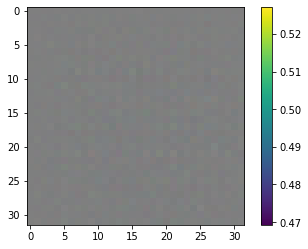

In [500]:
plt.imshow((generated_image[0, :, :, :]+1)/2)
plt.colorbar()
plt.show()

## 3. 판별자 모델 구현하기

(32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성

In [501]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.3))
    
   

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [502]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_85 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_86 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 8192)            

In [503]:
# 위 2단계에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00053613]], dtype=float32)>

## 4. 손실함수와 최적화 함수 구현하기

### 손실함수(loss function)

In [504]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### generator_loss

In [505]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### discriminator_loss

In [506]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 정확도(accuracy)

#### discriminator accuracy

In [507]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 생성자와 판별자를 최적화하는 optimizer

In [508]:
generator_optimizer = tf.keras.optimizers.Adam(lr=0.002, beta_1=0.5,beta_2= 0.999)  # 1e-4
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.002, beta_1=0.5,beta_2= 0.999)

## 5. 훈련과정 상세 기능 구현하기


학습이 매번 어떻게 진행되는지 확인을 휘해 생성자가 생성한 샘플을 확인할 것이다.

In [509]:
noise_dim = 100 # 100차원의 노이즈
num_examples_to_generate = 16 # 한 번에 16장의 샘플을 생성

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

#### train_step() 함수 : 1개 미니배치의 훈련 과정을 처리

In [510]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

#### generate_and_save_images() 함수 : 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화

In [511]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :]+1)/2)
        plt.axis('off')
   
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10_7/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

#### draw_train_history() 함수

In [512]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10_7/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

#### checkpoint 모듈을 설정

In [513]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_7/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 6. 학습 과정 진행하기

In [514]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [517]:
save_every = 5
EPOCHS = 200

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. 베이스라인모델 (기존 노드와 같게)

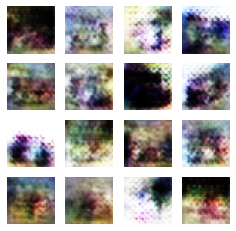

Time for training : 1491 sec


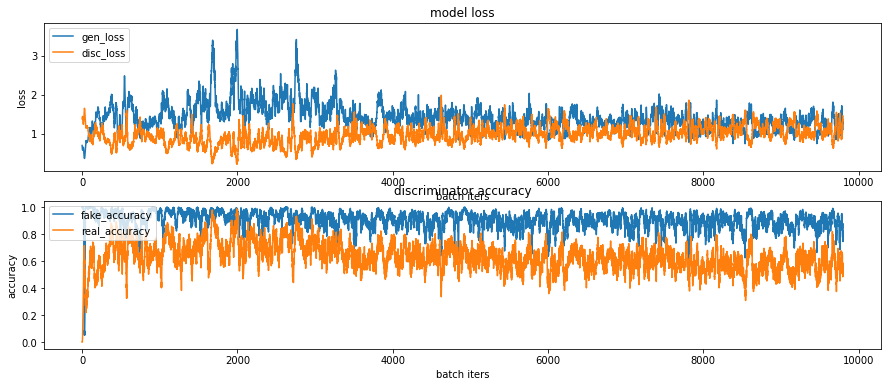

CPU times: user 24min 45s, sys: 30.9 s, total: 25min 16s
Wall time: 24min 52s


In [103]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

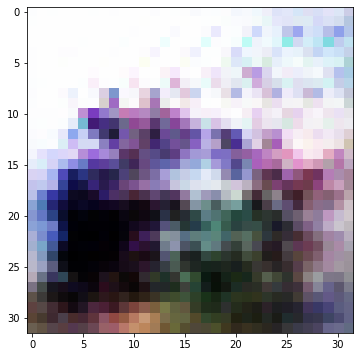

In [104]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [105]:
save_every = 5
EPOCHS = 200

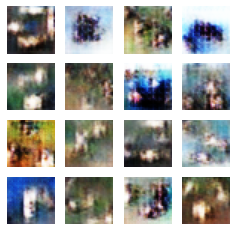

Time for training : 6100 sec


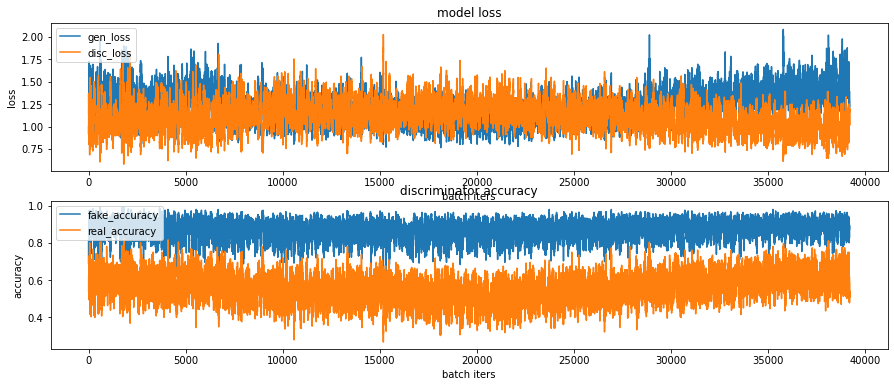

CPU times: user 1h 40min 41s, sys: 2min 36s, total: 1h 43min 18s
Wall time: 1h 41min 42s


In [106]:
%%time
train(train_dataset, EPOCHS, save_every)

loss가 안 떨어지고 fake_accuracy도 1에 가깝다.

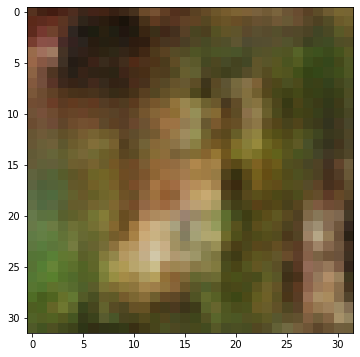

In [107]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

### GIF 

In [113]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 2537774 Sep  2 05:36 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


## 2. 옵티마이저 lr=0.001, beta_1=0.5, beta_2= 0.999 로 변경



In [216]:
save_every = 5
EPOCHS = 50

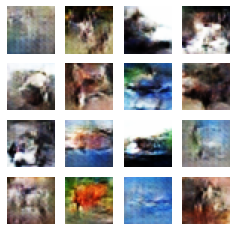

Time for training : 1496 sec


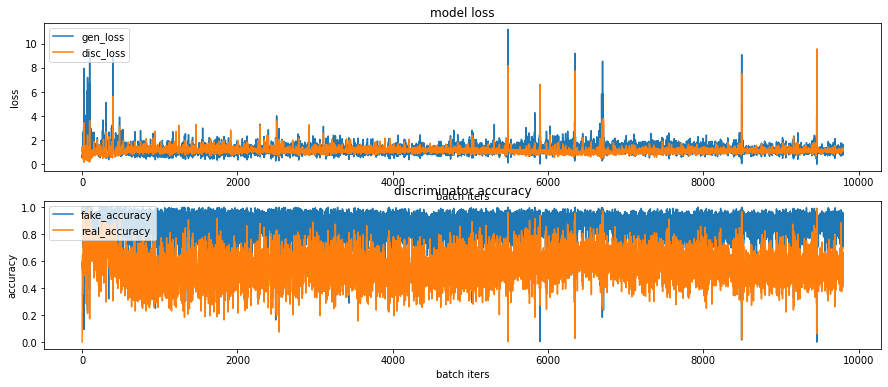

CPU times: user 24min 49s, sys: 31 s, total: 25min 20s
Wall time: 24min 57s


In [215]:
%%time
train(train_dataset, EPOCHS, save_every)


In [217]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_2/cifar10_2_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10_2/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10_2/cifar10_2_dcgan.gif

-rw-r--r-- 1 root root 1274926 Sep  2 06:45 /aiffel/aiffel/dcgan_newimage/cifar10_2/cifar10_2_dcgan.gif


## 3.  2번 + 모델바꿔보기(생성자와 판별자에 Conv 레이어 하나씩 추가)

In [247]:
save_every = 5
EPOCHS = 50

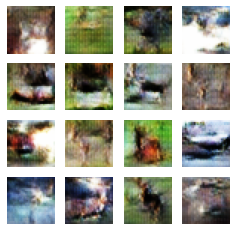

Time for training : 1848 sec


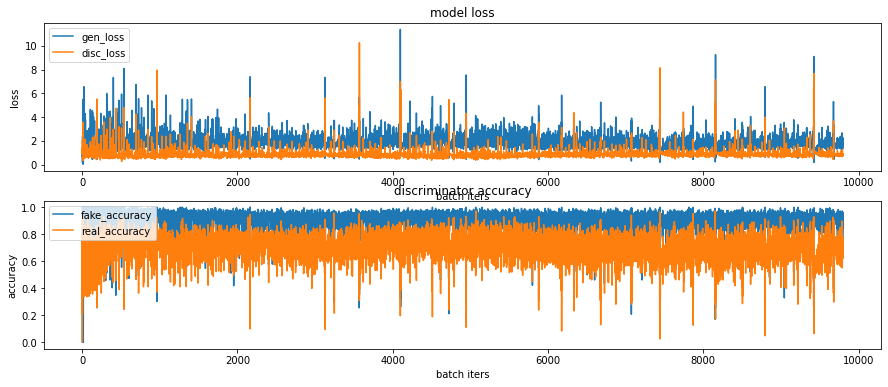

CPU times: user 30min 25s, sys: 38.5 s, total: 31min 3s
Wall time: 30min 49s


In [248]:
%%time
train(train_dataset, EPOCHS, save_every)

## 4. 3번 + 생성자모델에 드롭아웃 추가

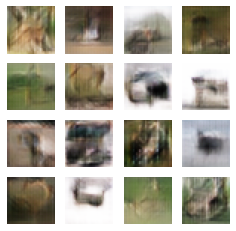

Time for training : 1851 sec


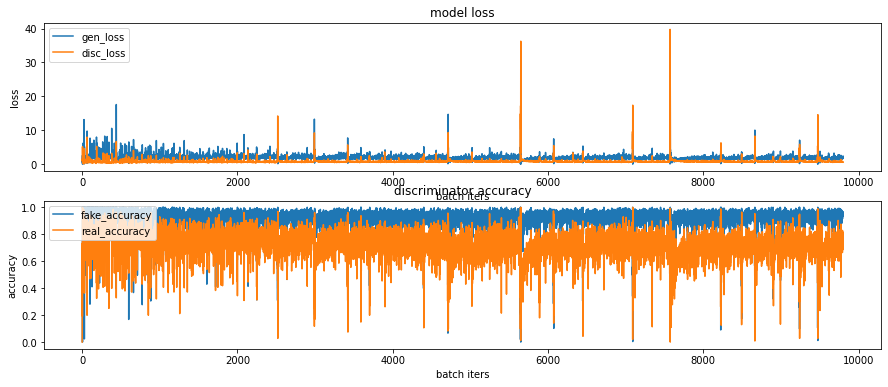

CPU times: user 30min 42s, sys: 27.6 s, total: 31min 9s
Wall time: 30min 52s


In [279]:
%%time
train(train_dataset, EPOCHS, save_every)

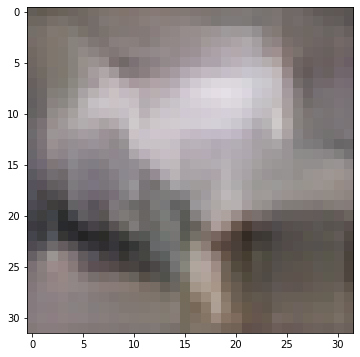

In [280]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_4/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

## 5. 4번+ 판별자 옵티마이저의 lr을 0.0002로변경 , 드롭아웃 다 없애기

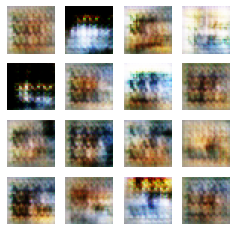

Time for training : 1743 sec


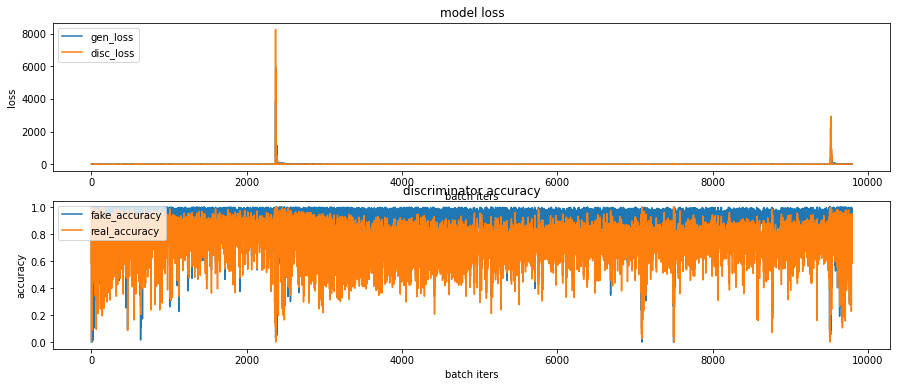

CPU times: user 29min 4s, sys: 34.6 s, total: 29min 39s
Wall time: 29min 4s


In [314]:
%%time
train(train_dataset, EPOCHS, save_every)

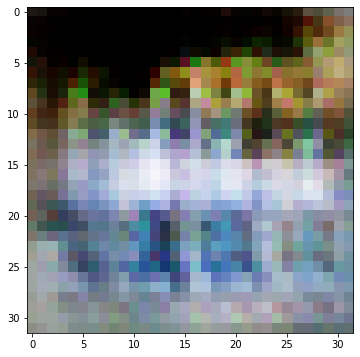

In [315]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_5/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [316]:
EPOCHS =200

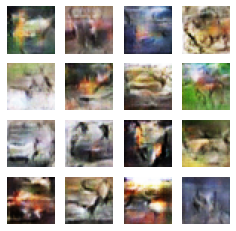

Time for training : 7123 sec


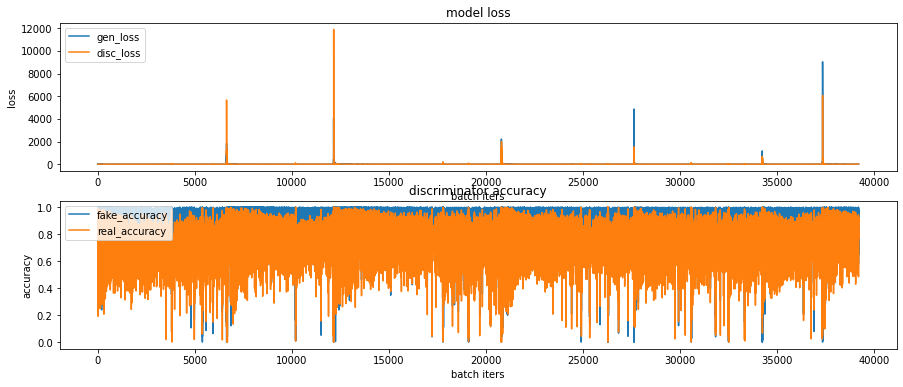

CPU times: user 1h 58min 15s, sys: 2min 50s, total: 2h 1min 6s
Wall time: 1h 58min 45s


In [317]:
%%time
train(train_dataset, EPOCHS, save_every)

loss가 처음부터 0으로만 나왔다. 판별자가 0으로 나오면 생성기가 고장난거라고 하여 고쳐야된다.

## 6. 5번에서  판별자모델에서만 드로아웃 살리기, 생성자 옵티마이저 lr (0.0001 -> 0.0002), noise_dim (100->130), conv 레이어 추가한거 삭제


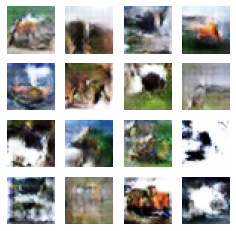

Time for training : 1508 sec


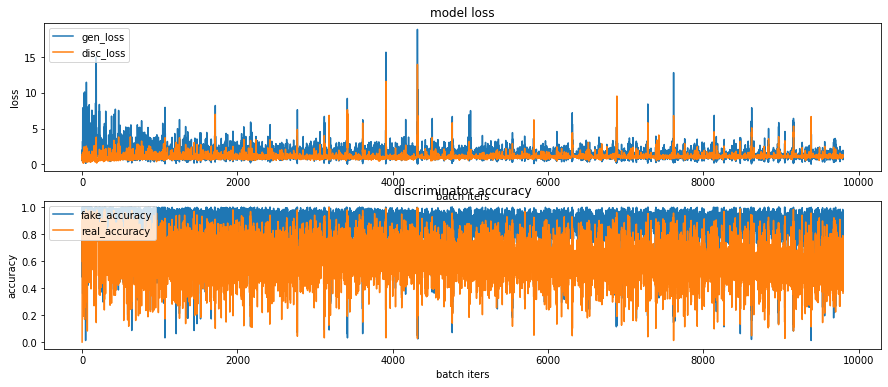

CPU times: user 24min 57s, sys: 37.1 s, total: 25min 34s
Wall time: 25min 9s


In [445]:
%%time
train(train_dataset, EPOCHS, save_every)

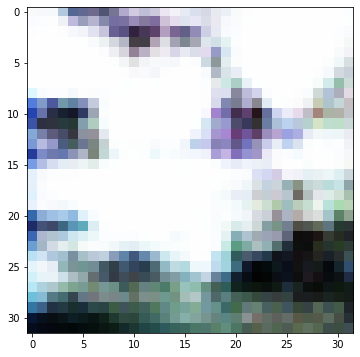

In [447]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_6/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 130])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

그래프 모양이 이상해서 중간에 정지함

## 7. 6번 + noise_dim (130 ->100)

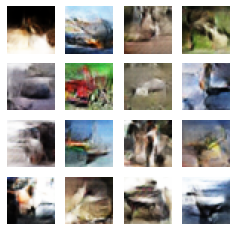

Time for training : 6147 sec


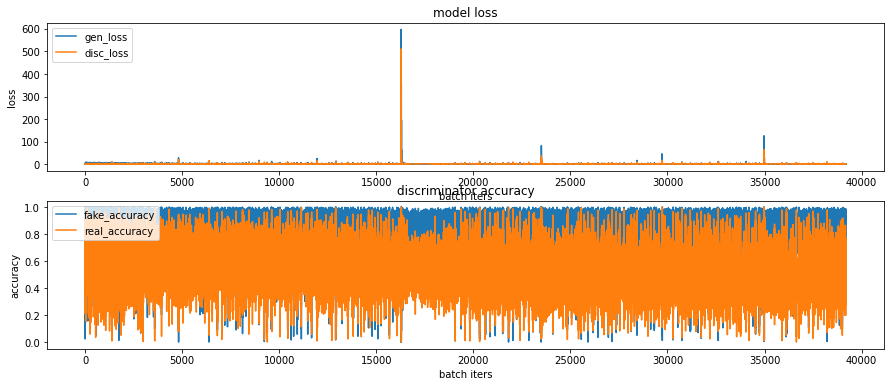

CPU times: user 1h 41min 37s, sys: 2min 21s, total: 1h 43min 58s
Wall time: 1h 42min 29s


In [518]:
%%time
train(train_dataset, EPOCHS, save_every)

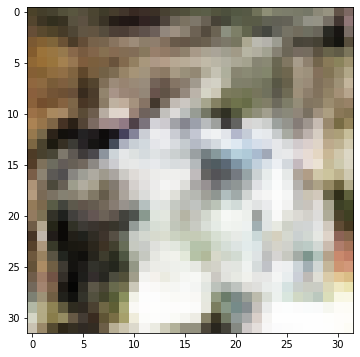

In [520]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_7/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

## GIF

In [524]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10_7/cifar10_7_2_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10_7/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10_7/cifar10_7_2_dcgan.gif

-rw-r--r-- 1 root root 2421523 Sep  2 14:48 /aiffel/aiffel/dcgan_newimage/cifar10_7/cifar10_7_2_dcgan.gif


In [522]:
EPOCHS=50

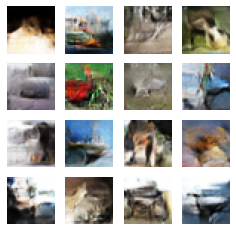

Time for training : 1518 sec


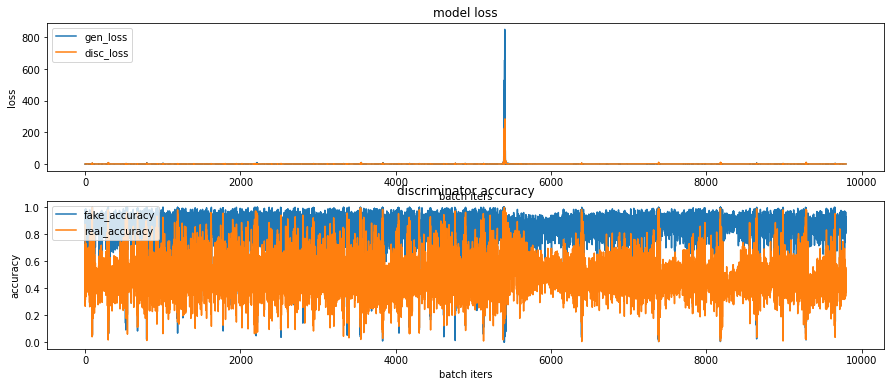

CPU times: user 25min 2s, sys: 38.9 s, total: 25min 41s
Wall time: 25min 19s


In [523]:
%%time
train(train_dataset, EPOCHS, save_every)

![](https://8888-w1q8mkqnovc5nmvfygqjm4m2u.e.aiffel-2.ainetwork.ai/files/aiffel/dcgan_newimage/cifar10_7/cifar10_7_dcgan.gif)
![](https://8888-w1q8mkqnovc5nmvfygqjm4m2u.e.aiffel-2.ainetwork.ai/files/aiffel/dcgan_newimage/cifar10_7/cifar10_7_2_dcgan.gif)

* 점점 선명해져가는 모습이 gif로 나타난다. 중간에 빨간색은 새인것 같다.

## 회고

### 느낀점

* 이미지가 생성된다는 자체는 너무 신기한데 한번 돌릴 때 오래걸리니깐 괴롭다............................
* fake_accuracy 1에서 0.5로 만들기 너무 어렵다!!!!
* 이것저것 바꿔봤는데 뭐가 뭔지 모르겠다. 어려운 익스....
* 시간이 더 있었으면 몇천 epoch으로 돌려보고 싶었는데 아쉽다.
* 체크포인트가 안 불러와져서 아쉽.. 체크포인트 공부를 다시 해야겠다.

### 생성된 이미지 확인
* 파라미터나 모델을 변형하고 대충 확인만 먼저 하려고 우선 50에폭으로 돌렸다. 그래서 노이즈가 많긴 하다.

|기존모델|사진|
|---|---|
|1번째 모델|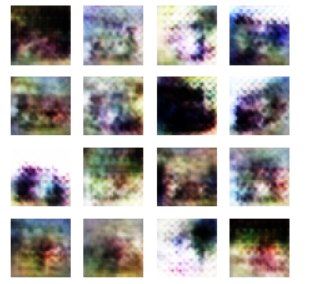|


|||
|---|---|
|3번째모델(개선)|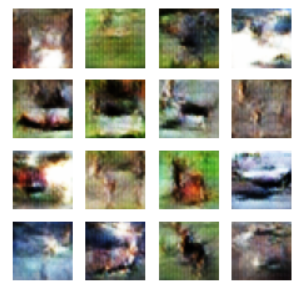|


* 1번째 모델은 노드와 동일한 모델이다.
* 3번째 모델은 1번모델에다가 생성자와 판별자에 Conv 레이어 하나씩 추가하고 옵티마이저의 파라미터를 lr=0.001, beta_1=0.5, beta_2= 0.999 로 변경하였다. <br>
=> 똑같이 50에폭을 했는데 1번 모델은 픽셀이 보이는 수준이고 3번 모델을 말같은 동물의 형상이 언뜻언뜻 보이는 것을 보아 기존모델보다 개선된 것으로 보임


### epoch

|5번째모델|사진|
|---|---|
|epoch_50|![](https://8888-w1q8mkqnovc5nmvfygqjm4m2u.e.aiffel-2.ainetwork.ai/files/aiffel/dcgan_newimage/cifar10_5/generated_samples/sample_epoch_0001_iter_001.png)|
|epoch_250|![](https://8888-w1q8mkqnovc5nmvfygqjm4m2u.e.aiffel-2.ainetwork.ai/files/aiffel/dcgan_newimage/cifar10_5/generated_samples/sample_epoch_0200_iter_195.png)|



* 같은 모델인데 epoch을 늘릴수록 점점 선명해진다.